# GAN: Theory

The generative model is pitted against an adversary:
* A discriminator $D$ estimates the probability of a given sample coming from the real dataset.
* A generator $G$ outputs synthetic samples given a noise variable.

### Setup
* $p_{data}$: data distribution over real samples $\mathbf{x}\in\mathcal{X}$.
* $p_g$: generators distribution over data $\mathbf{x}\in\mathcal{X}$.
* $p_{\mathbf{z}}(\mathbf{z})$: prior on input noise variables $\mathbf{z}\in\mathcal{Z}$
* Let $G:\mathcal{Z}\rightarrow\mathcal{X}$ be the generator $G(\mathbf{z};\theta_g)$
* Let $D:\mathcal{X}\rightarrow[0,1]$ be the discriminator $D(\mathbf{x};\theta_d)$, where $D(\mathbf{x})$ is the probability that $\mathbf{x}$ came from the data distribution $p_{data}$ than the generator distribution $p_g$.

### The Objective Function
$D$ and $G$ play the following **two-player minimax game** with the value function $V(D,G)$

$$\begin{align}
\underset{G}{\text{min }}\underset{D}{\text{max }}V(D,G)&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{x}\sim p_g(\mathbf{x})}\Big[\log \big(1-D(\mathbf{x})\big)\Big]
\end{align}$$

where 
* We want to make sure $D$'s decisions over the real data are accurate and so we want to maximise $\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]$, i.e. the probability of the data point $\mathbf{x}\sim p_{data}$ coming from the data distribution $p_{data}$. Whilst given a fake sample $G(\mathbf{z})$, $D$ is expected to output a probability $D(G(\mathbf{z}))\approx0$ by maximising $\mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]$.
* We want the generator $G$ to increase the chances of $D$ outputting a high probability for a fake example $G(\mathbf{z})$, thus minimising $\mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]$.

In practice, the original loss function may not provide sufficient gradients for $G$ to learn. This is because early in learning, $G$ is poor and $D$ can easily reject samples with high confidence such that $\log\Big(1-D\big(G(\mathbf{z})\big)\Big)\rightarrow0$ as $D\big(G(\mathbf{z})\big)\approx0$. Instead we can use the below loss function,

$$\underset{G}{\text{max }}\underset{D}{\text{max }}V(D,G)=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\Big[\log D\big(G(\mathbf{z})\big)\Big]$$

which has the same fixed point of the dynamics of $G$ and $D$ but provides much stronger gradients early in learning.

### Convegence Results
**Optimal value for $D$**<br>
In this setup, for $G$ fixed the optimal discriminator $D$ is 

$$D^{\star}_{G}(\mathbf{x})=\frac{p_{data}(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}$$

The training objective for $D$ can be interpreted as maximising the log-likelihood of the conditional probabiltiy $p(Y=y\mid \mathbf{x})$, where $y=1$ if $\mathbf{x}$ comes from $p_{data}$ and $y=0$ if $\mathbf{x}$ comes from $p_g$. The objective can be reformulated as,

$$\begin{align}
V(D^{\star}_G,G)&=\underset{D}{\text{max }}V(D,G)\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D^{\star}_G(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{x}\sim p_g(\mathbf{x})}\bigg[\log \Big(1-D^{\star}_G(\mathbf{x})\Big)\bigg]\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\bigg[\log\frac{p_{data}(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}\bigg]+ \mathbb{E}_{\mathbf{x}\sim p_g(\mathbf{x})}\bigg[\log\frac{p_g(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})}\bigg]
\end{align}$$

**Global Optimum**<br>
The generator minimises the original objective for a fixed discriminator $D$. Hence the global minimum of the virtual training criterion $V(D^{\star}_G,G)$ is achieved if and only if $p_g=p_{data}$. This means that $D^{\star}_G=\frac{1}{2}$ such that

$$\begin{align}
V(D^{\star}_G,G)&=KL\bigg(p_{data}||\frac{p_{data}+p_g}{2}\bigg)+ KL\bigg(p_g||\frac{p_{data}+p_g}{2}\bigg)-2\log2\\
&=2JSD(p_{data}||p_g)-2\log2
\end{align}$$

where $JSD$ is the [Jenson-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (the symmetric form of the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)). Since the Jensen–Shannon divergence between two distributions is always non-negative and zero only when they are equal, we that the optimal objective is $V(D^{\star},G^{\star})=\underset{G}{\text{min }}V(D^{\star}_G,G)=-2\log2$.

### The Training Algorithm
In practice, we must implement the game using an iterative, numerical approach. Optimizing $D$ to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. Instead, we alternate between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in $D$ being maintained near its optimal solution, so long as G changes slowly enough.

**For** epochs $1,...,N$ **do**:<br>
**For** k steps **do**:
1. Sample minibatch of size $m$ from data: $\mathbf{x}_1,...,\mathbf{x}_m\sim p_{data}(\mathbf{x})$
2. Sample minibatch of size $m$ from noise: $\mathbf{z}_1,...,\mathbf{z}_m\sim p_{\mathbf{z}}(\mathbf{z})$
3. Take a gradient ascent step on the discriminator parameters $\theta_d$

$$\nabla_{\theta_d}V(D,G)=\nabla_{\theta_d}\frac{1}{m}\sum^{m}_{i=1}\bigg[\log D(\mathbf{x}_i) +\log \Big(1-D\big(G(\mathbf{z}_i)\big)\Big)\bigg]$$

**end for** <br>
4. Sample minibatch of size $m$ from noise: $\mathbf{z}_1,...,\mathbf{z}_m\sim p_{\mathbf{z}}(\mathbf{z})$
5. Take a gradient descent step on the generator parameters $\theta_g$

$$\nabla_{\theta_g}V(D,G)=\nabla_{\theta_d}\frac{1}{m}\sum^{m}_{i=1}\log \Big(1-D\big(G(\mathbf{z}_i)\big)\Big)$$

**end for**

### Challenges 
Working with GANs in practice is challenging because:
1. Unstable optimisation procedure: generator and discriminator loss continue to oscillate without converging to clear stopping point.
2. Potential for mode collapse: generator can get stuck producing one of a few types of samples over and over again.
3. Difficulty in evaluation: due to the lack of a robust stopping criteria, it is difficult to know when exactly the GAN has finished training.

Tips and tricks for training a GAN: https://github.com/soumith/ganhacks

### References
Original GAN paper: https://arxiv.org/abs/1406.2661 <br>
Lilian Weng blog: https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html<br>
CS236 notes: https://deepgenerativemodels.github.io/notes/index.html <br>
NeurIPS GAN tutorial: https://arxiv.org/abs/1701.00160

# GAN: Code

**Resources**<br>
PyTorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN#gan<br>
https://github.com/BY571/GANs/blob/master/Basic%20GAN.ipynb

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)

## Load MNIST Dataset

In [2]:
# Download MNIST dataset, preprocess and save locally as .npz file
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=True,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [-1,+1]
# x_train = ((x_train.float() / 255) - 0.5) * 2
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])

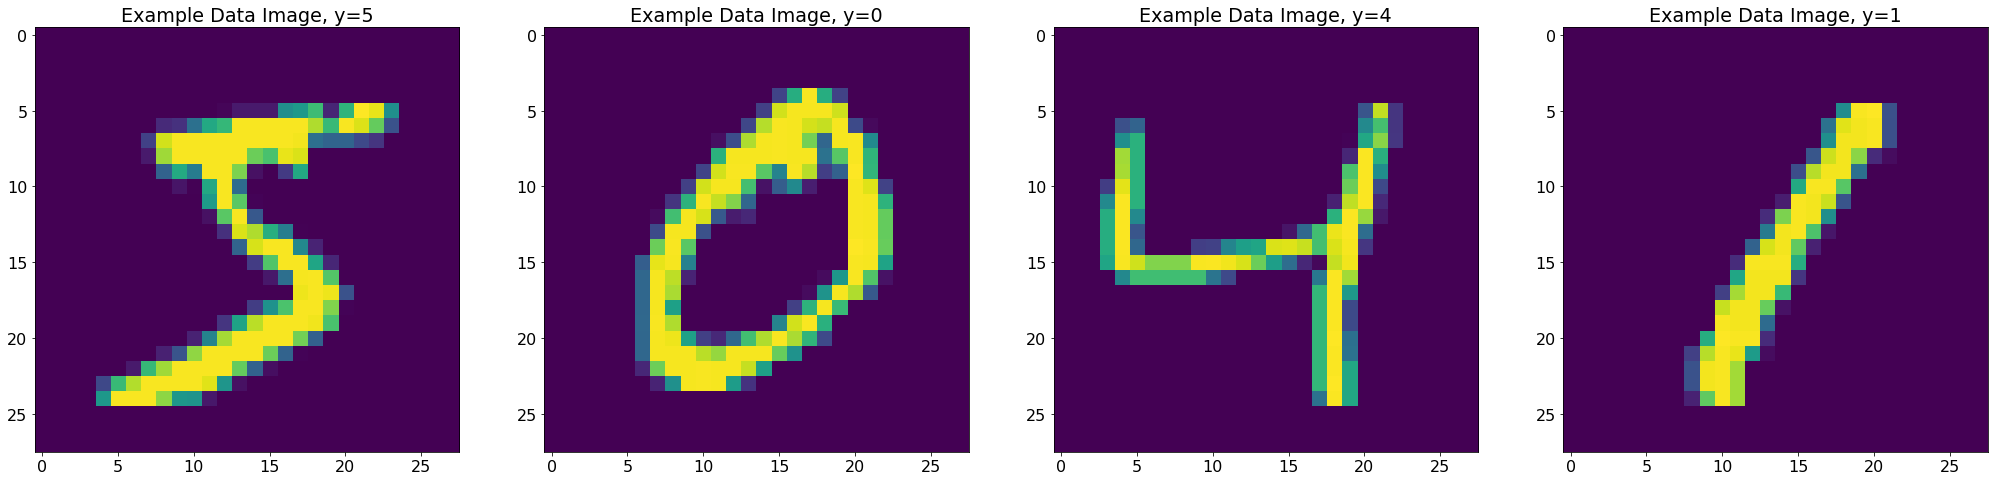

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=-1, vmax=1)
plt.show()

## Models

In [5]:
class Generator(nn.Module):
    def __init__(self, input_shape, output_shape):
        """
        Generator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Dimensionality of the latent space. (Default=100)
        output_shape : `int`
            Flattened size of image. (Default=784)
        """
        super(Generator, self).__init__()
        
        def block(in_shape, out_shape, normalize=True):
            layers = [nn.Linear(in_shape, out_shape)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_shape, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers        
        
#         self.model = nn.Sequential(*block(input_shape, 128, normalize=False),
#                                    *block(128, 128),
#                                    nn.Linear(128, output_shape),
#                                    nn.Tanh())
        self.model = nn.Sequential(*block(input_shape, 128, normalize=False),
                                   *block(128, 256),
                                   *block(256, 512),
                                   *block(512, 1024),
                                   nn.Linear(1024, output_shape),
                                   nn.Tanh())

    def forward(self, z):
        return self.model(z)     

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        """
        Discriminator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Flattened size of image. (Default=784)
        """        
        super(Discriminator, self).__init__()
#         self.model = nn.Sequential(nn.Linear(input_shape, 128),
#                                    nn.LeakyReLU(0.2, inplace=True),
#                                    nn.Linear(128, 128),
#                                    nn.LeakyReLU(0.2, inplace=True),
#                                    nn.Linear(128, 1),
#                                    nn.Sigmoid())    
        self.model = nn.Sequential(nn.Linear(input_shape, 512),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(512, 256),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid())        

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)    
        return self.model(x_flat)

## Training

In [7]:
# Hyperparameters
k = 1
z_dim  = 100
epochs = 200
batch_size = 2048
learning_rate = 2e-4

**Objective Function in Practice**<br>
In practice we use the binary cross entropy loss `torch.nn.BCELoss` given by

$$\mathcal{L}=-\frac{1}{m}\sum^{m}_{i=1}\Big[y_i\log(\mathbf{x}_i)+(1-y_i)\log(1-\mathbf{x}_i)\Big]$$

where $\mathbf{x}_i$ are the inputs and $y_i$ are the outputs. With the discriminator $D$ we have two cases
* inputs $=D(\mathbf{x})$ and outputs $=1$, such that $\mathcal{L}_{true}=-\frac{1}{m}\sum^{m}_{i=1}\log\big(D(\mathbf{x}_i)\big)$
* inputs $=D\big(G(\mathbf{z})\big)$ and outputs $=0$, such that $\mathcal{L}_{fake}=-\frac{1}{m}\sum^{m}_{i=1}\log\Big(1-D\big(G(\mathbf{z}_i)\big)\Big)$

summing these two together $\mathcal{L}_D=\mathcal{L}_{true}+\mathcal{L}_{fake}$ we obtain the original objective function which we wish to minimise

$$\begin{align}
\underset{D}{\text{max }}V(D,G)&=\underset{D}{\text{max }}\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]\\
&=\underset{D}{\text{max }}\frac{1}{m}\sum^{m}_{i=1}\bigg[\log\big(D(\mathbf{x}_i)\big)+ \log\Big(1-D\big(G(\mathbf{z}_i)\big)\Big)\bigg]\\
&=\underset{D}{\text{max }}-\mathcal{L}_D\\
&=\underset{D}{\text{min }}\mathcal{L}_D\\
\end{align}$$

On the otherhand, with the generator $G$ we have the single case
* inputs $=D\big(G(\mathbf{z})\big)$ and outputs $=1$, such that $\mathcal{L}_G=-\frac{1}{m}\sum^{m}_{i=1}\log\Big(D\big(G(\mathbf{z})\big)\Big)$

which again we wish to minimise. This is because as stated above we use the modified objective function 

$$\begin{align}
\underset{G}{\text{min }}\mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]&=\underset{G}{\text{max }}\mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\Big[\log D\big(G(\mathbf{z})\big)\Big]\\
&=\underset{G}{\text{max }}\sum^{m}_{i=1}\log\Big(D\big(G(\mathbf{z}_i)\big)\Big)\\
&=\underset{G}{\text{max }}-\mathcal{L}_G\\
&=\underset{G}{\text{min }}\mathcal{L}_G
\end{align}$$

In [8]:
# Create DatatLoader 
dataset    = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Loss function: we use the binary cross entropy loss
adversarial_loss = torch.nn.BCELoss()

# Initialize discriminator and generator
discriminator = Discriminator(np.prod(x_train[0].shape))
generator     = Generator(z_dim, np.prod(x_train[0].shape))

# Optimisers
optimiser_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimiser_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Send to GPU if available
discriminator.to(device)
generator.to(device)

print("Device: ", device)
print(discriminator)
print(generator)

Device:  cuda
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchN

In [9]:
# Training
measures = defaultdict(list)
start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    
    # Train Discriminator k times
    discriminator.train()
    generator.eval()     
    # NOTE: hand-crafting what k should be is very hard (why I set k=1),
    # instead use a more principled approach based on the loss of each model
    for step in range(k):  
        batch_loss_d = 0        
        for i, (X,_) in enumerate(dataloader):           
            X = X.to(device)
            # Adversarial ground truths
            y_true = torch.ones(X.size(0), 1, dtype=torch.float).to(device)
            y_fake = torch.zeros(X.size(0), 1, dtype=torch.float).to(device) 
            
            # Zero accumulated gradients
            discriminator.zero_grad()  
            
            # Sample noise as generator input
            z = torch.FloatTensor(np.random.normal(0, 1, (X.shape[0], z_dim))).to(device)      
            # Generate a batch of images
            gen_X = generator(z)   
            
            # Calculate loss           
            true_loss = adversarial_loss(discriminator(X), y_true)
            fake_loss = adversarial_loss(discriminator(gen_X.detach()), y_fake)
            d_loss = true_loss + fake_loss
            # Backpropogation: calculating gradients
            d_loss.backward()
            # Update parameters of discriminator
            optimiser_D.step() 
            
            # Save loss per batch
            batch_loss_d += d_loss.item()*X.size(0)            
        # Save discriminator losses per epoch
        measures['total_loss_d'].append(batch_loss_d / len(dataloader.dataset))
    
    # Train Generator
    discriminator.eval()
    generator.train()
    batch_loss_g = 0    
    for i, (X,_) in enumerate(dataloader): 
        # Zero accumulated gradients
        generator.zero_grad()
        
        # Sample noise as generator input
        z = torch.FloatTensor(np.random.normal(0, 1, (X.shape[0], z_dim))).to(device)  
        # Generate a batch of images
        gen_X = generator(z)
        
        # Calculate loss
        g_loss = adversarial_loss(discriminator(gen_X), 
                                  torch.ones(X.size(0), 1, dtype=torch.float).to(device) )
        # Backpropogation: calculating gradients
        g_loss.backward()
        # Update parameters of generator
        optimiser_G.step()  
        
        # Save first produced image every epoch
        if i == 0:
            measures['images'].append(gen_X[0].detach().cpu().numpy())
        # Save loss per batch
        batch_loss_g += g_loss.item()*X.size(0)            
    # Save generator losses per epoch
    measures['total_loss_g'].append(batch_loss_g / len(dataloader.dataset))
    
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "D Loss: {:.4f}...".format(measures['total_loss_d'][-1]),
          "G Loss: {:.4f}...".format(measures['total_loss_g'][-1]),
          "Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))    
    
print("Total Time Taken: {:,.4f} seconds".format(time.time()-start_time))

Epoch: 1/200... D Loss: 0.7430... G Loss: 0.4306... Time Taken: 1.9067 seconds
Epoch: 2/200... D Loss: 1.2257... G Loss: 0.4016... Time Taken: 2.0163 seconds
Epoch: 3/200... D Loss: 1.3294... G Loss: 0.4412... Time Taken: 1.9939 seconds
Epoch: 4/200... D Loss: 1.4856... G Loss: 0.6828... Time Taken: 1.8365 seconds
Epoch: 5/200... D Loss: 1.3178... G Loss: 0.3696... Time Taken: 1.7997 seconds
Epoch: 6/200... D Loss: 1.4613... G Loss: 0.6614... Time Taken: 1.8535 seconds
Epoch: 7/200... D Loss: 1.3665... G Loss: 0.4383... Time Taken: 1.7427 seconds
Epoch: 8/200... D Loss: 1.4157... G Loss: 0.6573... Time Taken: 1.8460 seconds
Epoch: 9/200... D Loss: 1.2816... G Loss: 0.5340... Time Taken: 1.8502 seconds
Epoch: 10/200... D Loss: 1.3130... G Loss: 0.5934... Time Taken: 1.8246 seconds
Epoch: 11/200... D Loss: 1.3082... G Loss: 0.6898... Time Taken: 1.7316 seconds
Epoch: 12/200... D Loss: 1.2829... G Loss: 0.5748... Time Taken: 1.7206 seconds
Epoch: 13/200... D Loss: 1.4196... G Loss: 0.5977

Epoch: 104/200... D Loss: 1.1359... G Loss: 0.7501... Time Taken: 1.8164 seconds
Epoch: 105/200... D Loss: 1.0743... G Loss: 0.8160... Time Taken: 2.0163 seconds
Epoch: 106/200... D Loss: 1.1305... G Loss: 0.8064... Time Taken: 1.8303 seconds
Epoch: 107/200... D Loss: 1.1182... G Loss: 0.7648... Time Taken: 1.7285 seconds
Epoch: 108/200... D Loss: 1.1065... G Loss: 0.6852... Time Taken: 1.7432 seconds
Epoch: 109/200... D Loss: 1.1243... G Loss: 0.6843... Time Taken: 1.8241 seconds
Epoch: 110/200... D Loss: 1.0657... G Loss: 0.6507... Time Taken: 1.7458 seconds
Epoch: 111/200... D Loss: 1.2278... G Loss: 0.6340... Time Taken: 2.0946 seconds
Epoch: 112/200... D Loss: 1.1890... G Loss: 0.6104... Time Taken: 2.1000 seconds
Epoch: 113/200... D Loss: 1.1880... G Loss: 0.6135... Time Taken: 2.0575 seconds
Epoch: 114/200... D Loss: 1.0814... G Loss: 0.6410... Time Taken: 1.8556 seconds
Epoch: 115/200... D Loss: 1.1807... G Loss: 0.6486... Time Taken: 1.7284 seconds
Epoch: 116/200... D Loss: 1.

## Results

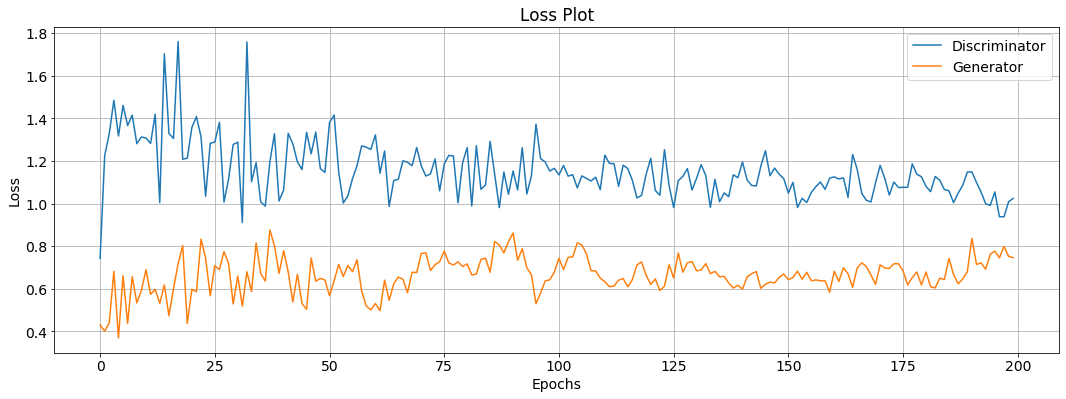

In [10]:
# Plot loss
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18,6))
plt.plot(measures['total_loss_d'], label='Discriminator')
plt.plot(measures['total_loss_g'], label='Generator')
plt.title('Loss Plot')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

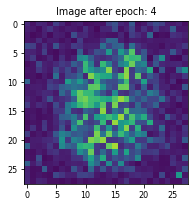

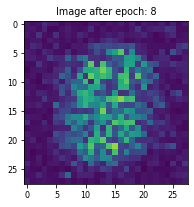

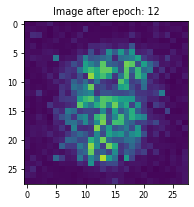

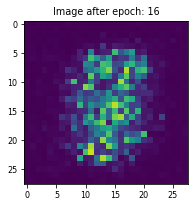

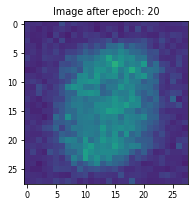

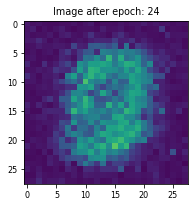

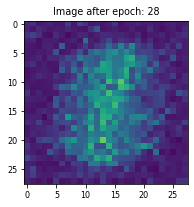

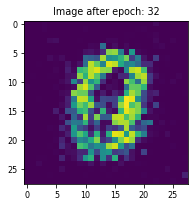

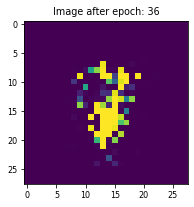

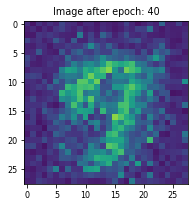

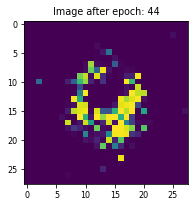

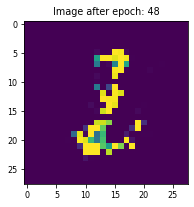

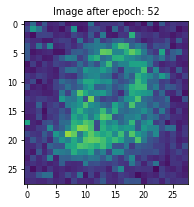

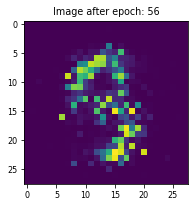

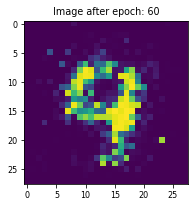

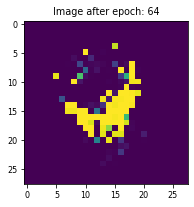

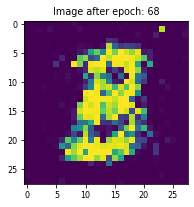

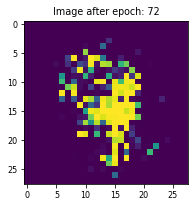

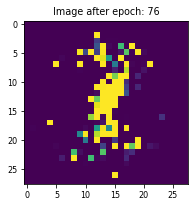

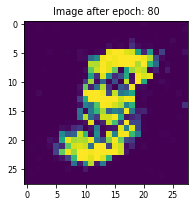

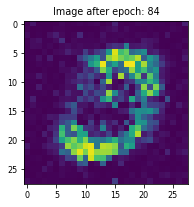

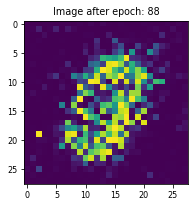

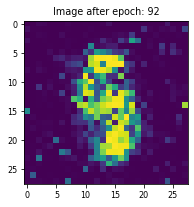

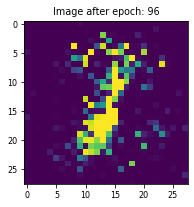

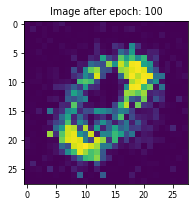

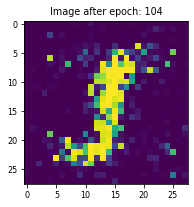

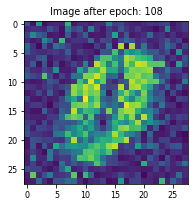

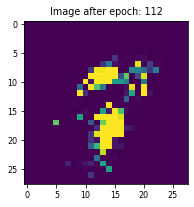

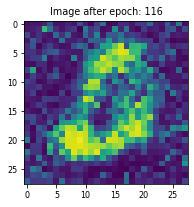

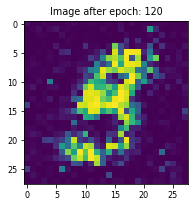

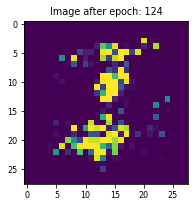

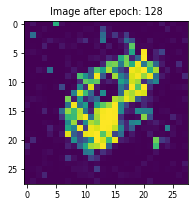

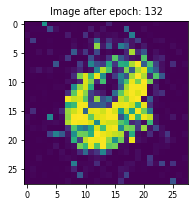

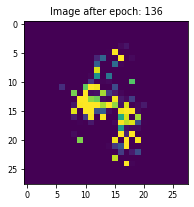

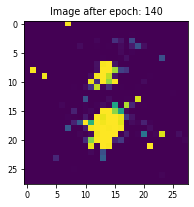

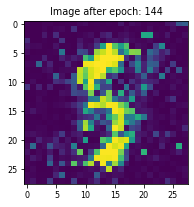

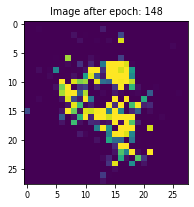

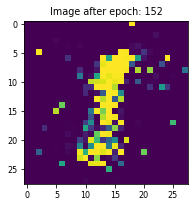

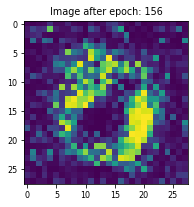

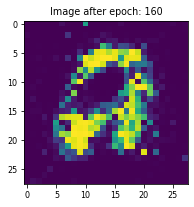

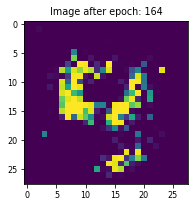

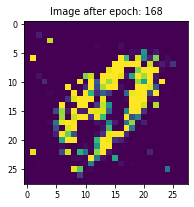

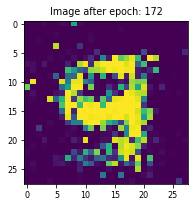

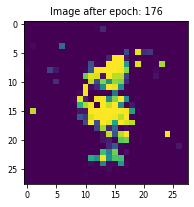

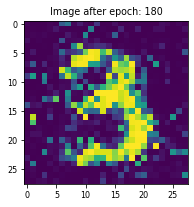

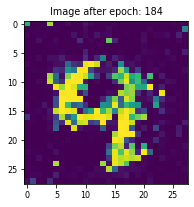

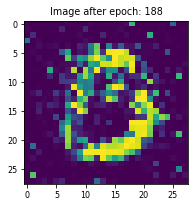

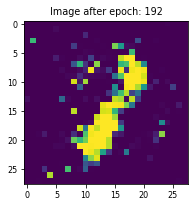

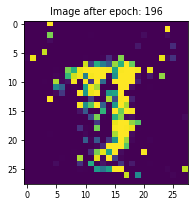

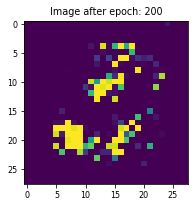

In [11]:
# Plot images generated by Generator
plt.rcParams.update({'font.size': 8})
for i, img in enumerate(measures['images']):
    i += 1
    if i % 4 ==0:
        plt.figure(figsize=(3,3))
        imx, imy = (28,28)
        visual = np.reshape(img, (imx,imy))
        plt.title('Image after epoch: %s' %i)
        plt.imshow(visual, vmin=-1, vmax=1)
        plt.show()